In [4]:
%load_ext skip_kernel_extension
import warnings
warnings.filterwarnings('ignore')

# import xgboost
import time
import random

import numpy as np
from time import sleep
from Pamona import *
from nonlinear_manifold import *
from union_com import *
import math
# from mmd_ma import *
import pandas as pd
from sklearn.feature_selection import *
from eval import *

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 

from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
from sklearn.metrics import roc_curve, auc
from scipy import stats
# from imblearn.over_sampling import SMOTE

import ot
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, explained_variance_score,accuracy_score,balanced_accuracy_score, f1_score
from sklearn.decomposition import PCA

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


##### Load A549 here

In [5]:
%% skip True
# LOAD Data and Labels
ge = pd.read_csv("./A549/A549_scRNA_1183Genes_2392cells_F100_C50.csv")
ge.index=ge["Unnamed: 0"]
ge = ge.drop(["Unnamed: 0"], axis=1)
ge = ge.T

snp = pd.read_csv("./A549/A549_scATAC_5154Loci_2392cells_F100_C50.csv")
snp.index=snp["Unnamed: 0"]
snp = snp.drop(["Unnamed: 0"], axis=1)
snp = snp.T

pheno = pd.read_csv("./Pamona/A549_labels.csv")
cellLabels = pd.read_csv("./A549/cellLabels.csv", header=None)[1:]
pheno["Labels"] = cellLabels[1]
labels = pheno[pheno["Labels"].isin(ge.index)]

ge = ge.reset_index(drop=True)
snp = snp.reset_index(drop=True)
labels = labels.reset_index(drop=True)

# SPLIT Train/Test
geXTrain, geXTest, geYTrain, geYTest = train_test_split(ge[ge.columns[:]],labels["Time"],test_size=0.2,random_state=11)
snpXTrain = snp[snp.columns[:]].loc[geXTrain.index]
snpXTest = snp[snp.columns[:]].loc[geXTest.index]

phenoYTrain = labels.iloc[geYTrain.index]
phenoYTest = labels.iloc[geYTest.index]

# REORDER AND PICK TOP Peaks
topSNP = pd.DataFrame(snpXTrain.std().sort_values(ascending=False)).index
snpXTrain = snpXTrain[topSNP[:1183]]
snpXTest = snpXTest[topSNP[:1183]]

topGE = pd.DataFrame(geXTrain.std().sort_values(ascending=False)).index
geXTrain = geXTrain[topGE[:]]
geXTest = geXTest[topGE[:]]

UsageError: Cell magic `%%` not found.


##### Load Liu Cancer here

In [6]:
# %%skip True  #skips cell
ge = pd.read_csv("./liu_scrna_preprocessed_with_genes.csv")

snp = pd.read_csv("./liu_scatac_preprocessed.csv")
snp.index=snp["rownames"]
snp = snp.drop(["rownames"], axis=1)
snp = snp.T

for col in snp.columns:
    snp[col] = [1 if i>0 else 0 for i in snp[col].to_list()]
    
geTemp = pd.read_csv("./liu_scrna_preprocessed.csv")
geTemp.index=geTemp["rownames"]
geTemp = geTemp.drop(["rownames"], axis=1)
geTemp = geTemp.T

ctnames=[]
for ct in geTemp.index:
    if "HCT" in ct:
        ctnames.append("HCT116")
    elif "Hela" in ct:
        ctnames.append("Hela")
    elif "K562" in ct:
        ctnames.append("K562")

celltypedf = pd.DataFrame(ctnames,columns=["CellType"])

ge = ge.reset_index(drop=True)
snp = snp.reset_index(drop=True)

transformer = Normalizer().fit(ge)  # fit does nothing.
geDF_norm = pd.DataFrame(transformer.transform(ge), index = ge.index, columns=ge.columns)

geDF_norm = geDF_norm
snpDF_norm = snp

topGE = pd.DataFrame(geDF_norm.std().sort_values(ascending=False)).index
geDF_norm_FS = geDF_norm[topGE[:10000]]

topSNP = pd.DataFrame(snpDF_norm.std().sort_values(ascending=False)).index
snpDF_norm_FS = snpDF_norm[topSNP[:10000]]

geXTrain, geXTest, geYTrain, geYTest = train_test_split(geDF_norm_FS[geDF_norm_FS.columns[:10000]],celltypedf['CellType'],test_size=0.4,random_state=11)
snpXTrain = snpDF_norm_FS[snpDF_norm_FS.columns[:10000]].loc[geXTrain.index]
snpXTest = snpDF_norm_FS[snpDF_norm_FS.columns[:10000]].loc[geXTest.index]

##### Load HCC here

In [2]:
%%skip True  #skips cell
ge = pd.read_csv("./human_cerebral_cortex/scRNAWithGenesSeurat_afterPreprocessing_09_08.csv")
snp = pd.read_csv("./human_cerebral_cortex/scATACWithLociSeurat_afterPreprocessing_09_08.csv")

ge = ge.reset_index(drop=True)
snp = snp.reset_index(drop=True)

geXTrain, geXTest = train_test_split(ge[ge.columns[:]],test_size=0.2,random_state=11)
snpXTrain = snp.loc[geXTrain.index]
snpXTest = snp.loc[geXTest.index]

In [6]:
# %%skip True  #skips cell

mod2 = geDF_norm_FS# < input reference modality here - Y (we know Y and Y_hat, for example SNP,RNA)> 
mod1 = snpDF_norm_FS# < input query modality here - X (we know only X, predict X_hat, for example GE,ELEC) >
labels = None# < input known phenotype labels here >

In [7]:
# %%skip True  #skips cell

hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
hclabels=hc.fit_predict(snpDF_norm_FS.to_numpy())
# hclabels = [",".join(item) for item in hclabels.astype(str)]
labels = pd.DataFrame(hclabels, columns = ["HC"])

In [8]:
##### Split into Train-Test
if labels is not None:
    mod2XTrain, mod2XTest, labelYTrain, labelYTest = train_test_split(mod2,labels,test_size=0.2,random_state=11)
else:
    mod2XTrain, mod2XTest = train_test_split(mod2,test_size=0.2,random_state=11)
mod1XTrain = mod1.loc[mod2XTrain.index]
mod1XTest = mod1.loc[mod2XTest.index]

##### Load PBMC here

In [9]:
%%skip True
mod2XTrain = pd.read_csv("./PBMC_Multigrate_Seurat/PBMC_Seurat_RNA_train_filtered.csv")
mod2XTest = pd.read_csv("./PBMC_Multigrate_Seurat/PBMC_Seurat_RNA_test_filtered.csv")

mod1XTrain = pd.read_csv("./PBMC_Multigrate_Seurat/PBMC_Seurat_ADT_train.csv")
mod1XTest = pd.read_csv("./PBMC_Multigrate_Seurat/PBMC_Seurat_ADT_test.csv")

##### Load MOFA+, Seurat predicted correlations

In [10]:
predCorrdf = pd.read_csv("predcorrdf_ROSMAP_80_20.csv")
predCorrdf.columns

Index(['MOFA+', 'CMOT_Unioncom', 'CMOT_clustering_align_1%',
       'CMOT_clustering_align_25%', 'CMOT_clustering_align_50%',
       'CMOT_clustering_align_75%', 'CMOT_clustering_align_100%', 'Seurat'],
      dtype='object')

##################################################################################################

**Input:** X & Y modalities for training; Y_hat as single modality;

**Output:** predict X_hat

In [8]:
def align_samples(X,Y,percent_align_n,d=5,mu=0.5, method="NMA"):
    random.seed(30)
    
    if method == "NMA":
        n = random.sample(range(0, len(X)), int((percent_align_n)*len(X)))
        obj = nonlinear_Manifold(X, Y,d,mu,percent_align=n)
        X_aligned,Y_aligned = obj.run(as_file=False)
    elif method == "Unioncom":
        d=5
        obj = Unioncom(X, Y,d,epoch_pd=700, epoch_DNN=900)
        X_aligned,Y_aligned = obj.run(as_file=False)
    return X_aligned,Y_aligned

def kmeans(X,Y,k=6):
    X_Y = pd.concat([X,Y]).to_numpy()

    kmeanModel = KMeans(n_clusters=6).fit(X)
    kmeanModel.fit(X_Y)
    clusterLabels = kmeanModel.labels_  
    return clusterLabels

def optimal_transport(Xs,Xt,reg_e, reg_cl,ys=None,method="lpl1_reg"):
   
    if method == "emd":
        ot_emd = ot.da.EMDTransport()
        ot_emd.fit(Xs=Xs, Xt=Xt)
        transp_Xs_emd = ot_emd.transform(Xs=Xs)        
        return transp_Xs_emd

    elif method == "sinkhorn":
        ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
        ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
        transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
        return transp_Xs_sinkhorn

    elif method == "lpl1_reg":
        ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=reg_e, reg_cl=reg_cl)
        ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)
        transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)        
        return transp_Xs_lpl1
       
    elif method == "emd_laplace":
        ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=10, reg_src=10)
        ot_emd_laplace.fit(Xs=Xs, Xt=Xt)
        transp_Xs_emd_laplace = ot_emd_laplace.transform(Xs=Xs)
        return transp_Xs_emd_laplace
        
    elif method == "l1l2_reg":
        ot_l1l2 = ot.da.SinkhornL1l2Transport(reg_e=1e-1, reg_cl=2e0, max_iter=20,
                                      verbose=True)
        ot_l1l2.fit(Xs=Xs, ys=ys, Xt=Xt)
        transp_Xs_l1l2 = ot_l1l2.transform(Xs=Xs)
        return transp_Xs_l1l2
    
def get_nn(X,ys,k,components,targetcomponent):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(components)
    neighDist, neigh = knn.kneighbors(targetcomponent, return_distance=True)
    nn = X.iloc[neigh[0]]
    nnL = ys[neigh[0]]
    
    return nn, nnL, neighDist,neigh

def get_corr_with_n(nn,targetGE):
    for idx,row in nn.iterrows():
        b = np.array(row).reshape(1,-1)
        corr = stats.pearsonr(targetGE[0][:150], b[0][:150])
        nnCorr.append(corr[0])
        
    return nnCorr

def get_phenotype(X,ys,transp_Xs,targetSNP,k,topFeat,pca=False):
    
#     targetSNP = Xt[targetIdx][:topFeat].reshape(1,-1)
    Xp = transp_Xs[:,:topFeat]

    if pca:
        pca = PCA(n_components=4)
        components = pca.fit_transform(Xp)
        targetcomponent = pca.transform(targetSNP)
    else:
        components = Xp
        targetcomponent = targetSNP
    
    nn,nnL,neighDist,neighIdx = get_nn(X,ys,k,components,targetcomponent)

    neighDist = neighDist[0]
    for i in range(len(neighDist)):
        neighDist[i] = math.exp(-neighDist[i])
    
    nn = nn.multiply(neighDist, axis=0)
    
    averageGE = nn.mean()
    return averageGE

def predict_phenotype(transp_Xs,Y_hat,X,ys,k,topFeat):

    predGEdf = pd.DataFrame(columns=X.columns)
    for i in range(len(Y_hat)):
        Y_hat_i = Y_hat.to_numpy()[i][:topFeat].reshape(1,-1)
        predGE = get_phenotype(X,ys,transp_Xs,Y_hat_i,k,topFeat)
        predGEdf = pd.concat([predGEdf,pd.DataFrame(predGE).T])
    return predGEdf

def check_correlation(predicted_p,X_hat):
    predCorr = []
    for i in range(len(predicted_p)):
        a = predicted_p.iloc[i][:]
        b = X_hat.iloc[i][:]
        corr = stats.pearsonr(a,b)
        predCorr.append(corr[0])
    return predCorr

def get_best_match(geNMA,snpNMA):
    best_match =[]
    for i in range(len(snpNMA)):
        X = geNMA.to_numpy()
        y_i = snpNMA.iloc[i].to_numpy().reshape(1,-1)
        knn = NearestNeighbors(n_neighbors=1).fit(X)
        dist,indices = knn.kneighbors(y_i)
        best_match.append(indices[0][0])
    return best_match


def find_best_match_df(best_match,geNMA, geXTrain):
    geNMABestMatch = geNMA.copy()
    geNMABestMatch = geNMABestMatch.reset_index()
    geNMABestMatch = geNMABestMatch.reindex(best_match)
    geNMABestMatch = geNMABestMatch.drop(["index"], axis=1)
    geNMABestMatch = geNMABestMatch.reset_index(drop=True)
    
    geXTrainBestMatch = geXTrain.copy()
    geXTrainBestMatch = geXTrainBestMatch.reset_index()
    geXTrainBestMatch = geXTrainBestMatch.reindex(best_match)
    geXTrainBestMatch = geXTrainBestMatch.drop(["index"], axis=1)
    geXTrainBestMatch = geXTrainBestMatch.reset_index(drop=True)
    
    return geNMABestMatch, geXTrainBestMatch

In [12]:
skf = StratifiedKFold(n_splits=5)
percent_align_n = 1
mean = []
 
topFeat=350
k=200

for train_index, test_index in skf.split(mod1, labels):
    
    X, X_hat = mod1.loc[train_index], mod1.loc[test_index]
    Y, Y_hat = mod2.loc[train_index], mod2.loc[test_index]
    
    if labels is not None:
        labelYTrain, labelYTest = labels.loc[train_index], labels.loc[test_index]
    
#     print ("Aligning modalities ...")
    X_aligned,Y_aligned = align_samples(X,Y,percent_align_n,d=5,mu=0.5)
    best_match = get_best_match(X_aligned,Y_aligned)
    X_NMABestMatch, X_BestMatch = find_best_match_df(best_match,X_aligned, X)
    
#     clusterLabels = kmeans(X_NMABestMatch,Y_aligned)

    # HERE Xs, ys, Xt are variables for OT i.e. Xs = Y, Xt = Y_hat, ys=known labels
    Xs = Y.to_numpy()
#     ys = clusterLabels[:len(Y)]
    ys = labelYTrain.to_numpy()
    Xt = Y_hat.to_numpy() 
    method = "emd"

#     print ("Starting Optimal transport using:", method)
    transp_Xs = optimal_transport(Xs,Xt,ys, method)

#     print ("Predicting phenotype ...")
    X_hat_pred = predict_phenotype(transp_Xs,Y_hat,X_BestMatch,ys,k,topFeat)
    predtion_Corr=  check_correlation(X_hat_pred,X_hat)
    print ("##################################################################################")
    print ("Mean correlation:")
    print ( "CMOT_Prediciton",pd.DataFrame(predtion_Corr, columns=["CMOT_Prediction"]).mean()[0])
    print ("MOFA+",predCorrdf[["MOFA+"]].mean()[0])
    print ("Seurat", predCorrdf[["Seurat"]].mean()[0])
    print ("\n")
    print ("Max correlation:")
    print ("CMOT_Prediction", pd.DataFrame(predtion_Corr, columns=["CMOT_Prediction"]).max()[0])
    print ("MOFA+",predCorrdf[["MOFA+"]].max()[0])
    print ("Seurat",predCorrdf[["Seurat"]].max()[0])
    print ("\n")
    print ("Median correlation:")
    print ("CMOT_Prediction",pd.DataFrame(predtion_Corr, columns=["CMOT_Prediction"]).median()[0])
    print ("MOFA+",predCorrdf[["MOFA+"]].median()[0])
    print ("Seurat",predCorrdf[["Seurat"]].median()[0])
    print ("##################################################################################")
    
    mean.append()

##################################################################################
Mean correlation:
CMOT_Prediciton 0.9417681276907193
MOFA+ 0.9350190797599628
Seurat 0.9304362215383665


Max correlation:
CMOT_Prediction 0.9876488057167485
MOFA+ 0.9911669964557466
Seurat 0.9843790491273984


Median correlation:
CMOT_Prediction 0.94806473835396
MOFA+ 0.9478044067772674
Seurat 0.9424946649529214
##################################################################################


TypeError: append() takes exactly one argument (0 given)

In [13]:
predCorrdf[["MOFA+"]].mean()[0]

0.9350190797599628

#### Calculate Runtimes for CMOT

In [9]:
runtimes = []
reg_e=5e03
reg_cl=1e00
percent_align_n = 1
topFeat=50
k=10


for i in range(1):
    start = time.time()
#     X = mod1XTrain #GE
#     Y = mod2XTrain #SNP
#     X_hat = mod1XTest
#     Y_hat = mod2XTest
    
    #FOR GE FROM SNP
#     X = geXTrain 
#     Y = snpXTrain 
#     X_hat = geXTest
#     Y_hat = snpXTest
    
    # FOR SNP FROM GE
    X = snpXTrain #GE
    Y = geXTrain #SNP
    X_hat = snpXTest
    Y_hat = geXTest
    

#     print ("Aligning modalities ...")
    X_aligned,Y_aligned = align_samples(X,Y,percent_align_n,d=5,mu=0.5)
    best_match = get_best_match(X_aligned,Y_aligned)
    X_NMABestMatch, X_BestMatch = find_best_match_df(best_match,X_aligned, X)
    
    #MAKRE SURE TO CHANGE NUMBER OF CLUSTERS ACCORDING TO DATASET
    hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
    hclabels=hc.fit_predict(Y)
    l = pd.DataFrame(hclabels, columns = ["HC"])

    # HERE Xs, ys, Xt are variables for OT i.e. Xs = Y, Xt = Y_hat, ys=known labels
    Xs = Y.to_numpy()
#     ys = clusterLabels[:len(Y)]
    ys = l["HC"].to_numpy()
    Xt = Y_hat.to_numpy() 
    method = "lpl1_reg"

#     print ("Starting Optimal transport using:", method)
    transp_Xs = optimal_transport(Xs,Xt,reg_e, reg_cl,ys, method)

#     print ("Predicting phenotype ...")
    X_hat_pred = predict_phenotype(transp_Xs,Y_hat,X_BestMatch,ys,k,topFeat)
    predtion_Corr=  check_correlation(X_hat_pred,X_hat)
    print ("Completed prediction!")
    print ("Total runtime:",time.time()-start)
    runtimes.append(time.time()-start)

Completed prediction!
Total runtime: 2.1950278282165527


<AxesSubplot:>

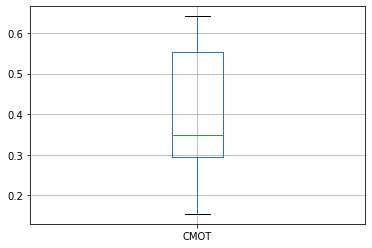

In [10]:
pd.DataFrame(predtion_Corr, columns=["CMOT"]).boxplot()

In [9]:
avg_time = sum(runtimes)/len(runtimes)
round(avg_time,2)

12.16

In [43]:
X_hat_pred

,MBP,GFAP,MT3,NRGN,CLU,PTGDS,FTL,SNAP25,ALDOA,TUBA1B,...,KCNJ4,CNN3,MRPL55,PSMC5,GNAO1,PRKACB,RGCC,BIN1,NDUFA8,NCALD
0,0.215962,0.221578,0.246075,0.13982,0.235637,0.163181,0.156388,0.060474,0.11207,0.092219,...,0.004927,0.004929,0.007212,0.010926,0.00991,0.004103,0.005752,0.012232,0.008097,0.003337
0,0.221621,0.230604,0.248126,0.13064,0.235455,0.159403,0.160334,0.060821,0.106623,0.091247,...,0.004687,0.005183,0.006918,0.011028,0.009602,0.004183,0.005903,0.011984,0.008185,0.003196
0,0.218238,0.222344,0.246689,0.140295,0.233608,0.163468,0.156773,0.060363,0.112151,0.091829,...,0.00494,0.004875,0.007271,0.010946,0.009829,0.004056,0.005731,0.01227,0.008109,0.003324
0,0.189445,0.208594,0.22955,0.155812,0.237425,0.158335,0.145403,0.072136,0.124424,0.10266,...,0.005577,0.004755,0.007735,0.011442,0.010549,0.004613,0.005309,0.012325,0.008715,0.004008
0,0.217178,0.221919,0.246266,0.140143,0.234728,0.163801,0.15657,0.060388,0.111889,0.092137,...,0.004945,0.004918,0.00723,0.010943,0.00989,0.004079,0.005749,0.012255,0.008111,0.003329
0,0.218565,0.222034,0.246812,0.140923,0.23407,0.163739,0.157119,0.060779,0.111923,0.092322,...,0.004975,0.004939,0.007273,0.010953,0.009886,0.004088,0.005762,0.01228,0.008149,0.003367
0,0.216958,0.222568,0.24695,0.140584,0.236033,0.163519,0.156932,0.060683,0.112281,0.092772,...,0.004976,0.004949,0.007241,0.01096,0.009974,0.004117,0.005786,0.012298,0.008145,0.003359
0,0.213821,0.211425,0.238745,0.146705,0.234646,0.159277,0.152392,0.066765,0.116888,0.097319,...,0.00519,0.004779,0.007333,0.011101,0.010275,0.004413,0.005535,0.012199,0.008355,0.003788
0,0.18616,0.207896,0.230321,0.157334,0.238795,0.159067,0.14454,0.072538,0.125258,0.103259,...,0.005615,0.00475,0.007791,0.011468,0.010606,0.004625,0.005313,0.012352,0.008739,0.004031
0,0.217619,0.223081,0.247043,0.14055,0.235746,0.163619,0.1568,0.060671,0.112275,0.092694,...,0.004966,0.004943,0.007247,0.010958,0.009952,0.004116,0.005803,0.012311,0.008143,0.003346


In [44]:
MOFApred = pd.read_csv("./MOFA_imputed_ROSMAP_GE.csv")
# MOFApred.index = MOFApred["Unnamed: 0"]
# MOFApred = MOFApred.drop(["Unnamed: 0"], axis=1)
# MOFApred = MOFApred.T
# MOFApred = MOFApred.reset_index(drop=True)
# MOFApred

# MOFApred = MOFApred[-51:]

predCorrMOFA = []
for i in range(len(MOFApred)):
    a = MOFApred.iloc[i][:]
    b = X_hat.iloc[i][:]
    corr = stats.pearsonr(a,b)
    predCorrMOFA.append(corr[0])

In [45]:
predtion_Corr

[0.8819680497724112,
 0.9721258012507401,
 0.9805685567047402,
 0.9824845225027259,
 0.8612732103206302,
 0.9353006609891139,
 0.8872815902733876,
 0.856088917294918,
 0.8542736129748746,
 0.9127096875941785,
 0.916649371402424,
 0.9590045412253948,
 0.9383509322522914,
 0.8947989452454592,
 0.8779528495418679,
 0.8893551302195528,
 0.8762583053919518,
 0.9143195563366503,
 0.9516954265606536,
 0.9351700799556654,
 0.7321411545147138,
 0.9347716081556058,
 0.9405309195903515,
 0.8800587878216292,
 0.9795025773476356,
 0.924420134221009,
 0.9719079780752157,
 0.9506490631740797,
 0.9321446847781747,
 0.9770551974435855,
 0.913721701481642,
 0.9430805940106409,
 0.9892470773341021,
 0.9713646594570511,
 0.9579675419299151,
 0.9855548248826698,
 0.977185394822554,
 0.9563456121898929,
 0.9182345125609772,
 0.6804446638753017,
 0.771775962392899,
 0.9612726479768581,
 0.8785047691504733,
 0.8783809811986881,
 0.9603260262752111,
 0.8975109863249939,
 0.9574193375483876,
 0.8870909626208203

In [46]:
predCorrdf = pd.DataFrame(predtion_Corr,columns=['CMOT_clustering'])
predCorrdf["MOFA+"] = predCorrMOFA

df = pd.DataFrame(columns=["CMOT","MOFA+"])
df.loc["Mean \ncorrelation"] = predCorrdf.mean()

In [47]:
seuratCorr = [0.9277504124543483,
 0.9810311341435238,
 0.9718438234498497,
 0.9871670666894896,
 0.9015693622315528,
 0.9344781973909385,
 0.9272883436821672,
 0.9173956277918374,
 0.864892266292827,
 0.9395216542783325,
 0.9414501870963133,
 0.9669586700238845,
 0.9259233949409168,
 0.9553211627557432,
 0.9168011492113513,
 0.9149729939253788,
 0.9365844613196062,
 0.9467400377815167,
 0.947583941646314,
 0.942365844144423,
 0.7443527547864296,
 0.9557969656352285,
 0.9522651833577265,
 0.9064044910063547,
 0.9772066820515395,
 0.8735812489580761,
 0.9786938059927054,
 0.9557307275728614,
 0.9221623708027873,
 0.9843218314605442,
 0.936353649784899,
 0.9491802717935207,
 0.9825519732235904,
 0.9791993937540917,
 0.9520854196637722,
 0.9767394146928516,
 0.9772898843582494,
 0.9787674081996964,
 0.9319352010098463,
 0.7055301945894832,
 0.8317328219255395,
 0.9627877439134784,
 0.9445138754167258,
 0.896179357612554,
 0.9665412891594236,
 0.911384886263447,
 0.9716040216516999,
 0.9043507404793713,
 0.971221355182617,
 0.8573201581464882,
 0.9766096308411782]

In [48]:
predCorrdf["Seurat"] = seuratCorr

<AxesSubplot:>

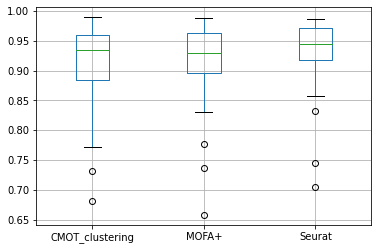

In [50]:
predCorrdf.boxplot()